# STEM Digital Twin (Twisted JSON-RPC) — Colab Notebook
This notebook runs a **local digital twin STEM server** (Twisted + netstring JSON-RPC) and a **Python client**.

Features:
- 10,000×10,000 synthetic **gold nanoparticle sample**
- Camera imaging via **subpixel bilinear sampling** (0.1 µm motion is visible)
- **Field of view (FOV)** zoom in/out
- **Defocus blur** model + **autofocus** (sharpness maximization)
- Base64 ndarray transport over JSON-RPC (robust)

**Port:** 9094 (fixed).

In [ ]:
!pip -q install twisted

In [ ]:

%%writefile stem_server_twisted_colab.py
from twisted.internet import reactor, protocol, threads
from twisted.internet.protocol import Factory
import json, time, base64
import numpy as np
from dataclasses import dataclass, field
from typing import Dict, Any, List, Tuple

# =========================
# Simulated microscope state
# =========================
@dataclass
class SimMicroscope:
    stage: Dict[str, float] = field(default_factory=lambda: {"x":0.0,"y":0.0,"z":0.0,"a":0.0,"b":0.0})
    beam: Dict[str, float]  = field(default_factory=lambda: {"x":0.0,"y":0.0,"current_pA":50.0,"voltage_kV":200.0})
    vacuum: float = 1e-6
    status: str = "Idle"
    holder_type: str = "DoubleTilt"
    mode: str = "IMG"
    diff: Dict[str, float] = field(default_factory=lambda: {"camera_length_mm": 800.0, "beamstop_radius_px": 6.0})

# =========================
# Detector defaults
# =========================
def default_haadf(detector_dict):
    detector_dict["haadf"] = {
        "size": 256,
        "exposure": 0.1,
        "binning": 1,
        "field_of_view_um": 20.0,   # FOV control (um)
        "noise_sigma": 12.0,
    }

# =========================
# Transport helpers
# =========================
def serialize_ndarray_b64(arr: np.ndarray) -> Dict[str, Any]:
    raw = arr.tobytes(order="C")
    b64 = base64.b64encode(raw).decode("ascii")
    return {"__ndarray_b64__": b64, "shape": arr.shape, "dtype": str(arr.dtype)}

# =========================
# Image processing helpers
# =========================
def box_blur_2d(img: np.ndarray, radius: int) -> np.ndarray:
    """
    Size-preserving box blur using an integral image.
    Output has the SAME shape as input.
    """
    if radius <= 0:
        return img
    H, W = img.shape
    r = int(radius)
    win = 2 * r + 1
    area = float(win * win)

    ap = np.pad(img, ((r, r), (r, r)), mode="edge").astype(np.float32)
    I = np.pad(ap, ((1, 0), (1, 0)), mode="constant").cumsum(axis=0).cumsum(axis=1)

    y1 = np.arange(0, H, dtype=np.int32)
    y2 = y1 + win
    x1 = np.arange(0, W, dtype=np.int32)
    x2 = x1 + win

    S = (
        I[np.ix_(y2, x2)]
        - I[np.ix_(y1, x2)]
        - I[np.ix_(y2, x1)]
        + I[np.ix_(y1, x1)]
    )
    out = S / area
    return np.clip(out, 0, 65535).astype(img.dtype)

def sharpness_metric(img_u16: np.ndarray) -> float:
    img = img_u16.astype(np.float32)
    gx = np.abs(img[:, 1:] - img[:, :-1]).mean()
    gy = np.abs(img[1:, :] - img[:-1, :]).mean()
    return float(gx + gy)

def bilinear_sample(img: np.ndarray, y: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    img: 2D uint16
    y,x: float32 arrays of same shape (pixel coords)
    returns: float32 sampled image
    """
    H, W = img.shape
    x0 = np.floor(x).astype(np.int32)
    y0 = np.floor(y).astype(np.int32)
    x1 = x0 + 1
    y1 = y0 + 1

    x0 = np.clip(x0, 0, W - 1); x1 = np.clip(x1, 0, W - 1)
    y0 = np.clip(y0, 0, H - 1); y1 = np.clip(y1, 0, H - 1)

    Ia = img[y0, x0].astype(np.float32)
    Ib = img[y1, x0].astype(np.float32)
    Ic = img[y0, x1].astype(np.float32)
    Id = img[y1, x1].astype(np.float32)

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return Ia*wa + Ib*wb + Ic*wc + Id*wd

# =========================
# 3D Sample generator (Au nanoparticles volume)
# =========================
def generate_gold_nanoparticle_volume(D: int, H: int, W: int, seed: int = 123, n_particles: int = 1200) -> np.ndarray:
    """
    Returns a 3D 'density' volume V[z,y,x] as uint16.
    It's a synthetic blobby nanoparticle-like structure, but now 3D so tilt has meaning.
    """
    rng = np.random.default_rng(seed)
    V = rng.normal(loc=150.0, scale=6.0, size=(D, H, W)).astype(np.float32)

    for _ in range(n_particles):
        cz = int(rng.integers(0, D))
        cy = int(rng.integers(0, H))
        cx = int(rng.integers(0, W))

        # 3D ellipsoid radii (voxels)
        rz = int(rng.integers(1, 6))
        ry = int(rng.integers(3, 18))
        rx = int(rng.integers(3, 18))

        intensity = float(rng.uniform(800.0, 6000.0))

        z0 = max(0, cz - rz*2); z1 = min(D, cz + rz*2 + 1)
        y0 = max(0, cy - ry*2); y1 = min(H, cy + ry*2 + 1)
        x0 = max(0, cx - rx*2); x1 = min(W, cx + rx*2 + 1)

        zz, yy, xx = np.mgrid[z0:z1, y0:y1, x0:x1]
        dz = (zz - cz).astype(np.float32)
        dy = (yy - cy).astype(np.float32)
        dx = (xx - cx).astype(np.float32)

        d = (dx*dx)/(rx*rx + 1e-6) + (dy*dy)/(ry*ry + 1e-6) + (dz*dz)/(rz*rz + 1e-6)
        profile = np.exp(-2.2 * d).astype(np.float32)

        V[z0:z1, y0:y1, x0:x1] += intensity * profile

    return np.clip(V, 0, 65535).astype(np.uint16)

# =========================
# STEMServer (Digital Twin)
# =========================
class STEMServer(object):
    def __init__(self):
        print("STEMServer (DT) init")
        self.detectors: Dict[str, Dict[str, Any]] = {}
        default_haadf(self.detectors)

        self.sim = SimMicroscope()
        self.command_log: List[Dict[str, Any]] = []

        # Focus plane (meters)
        self.focus_plane_z_m = 0.0

        # 3D volume (keep modest for Colab performance)
        D, H, W = 72, 2048, 2048
        print(f"[DT] Generating 3D Au volume {D}x{H}x{W} (one-time) ...")
        self.vol = generate_gold_nanoparticle_volume(D, H, W, seed=123, n_particles=1200)
        print("[DT] 3D volume ready.")
        self.vol_D = D

        # Physical mapping: interpret full width as sample_fov_um
        self.sample_fov_um = 200.0                 # 2048 px ~ 200 µm => ~10.24 px/µm
        self.sample_px_per_um = W / self.sample_fov_um

        # Tilt proxy scaling (voxels shifted per slice at tan(theta)=1)
        # Increase slightly if you want more dramatic tilt effects.
        self.tilt_strength_px_per_slice = 0.35

        print("STEMServer (DT) initialized")

    def _log(self, method: str, params: Any, result: Any = None):
        self.command_log.append({
            "t": time.time(),
            "method": method,
            "params": params,
            "result_preview": str(result)[:200],
        })

    # --- demo helpers
    def get_command_log(self, last_n: int = 50):
        return self.command_log[-int(last_n):]

    def clear_command_log(self):
        self.command_log = []
        return 1


    def get_beam(self):
        b = self.sim.beam
        r = {"x": float(b.get("x", 0.0)),
             "y": float(b.get("y", 0.0)),
             "current_pA": float(b.get("current_pA", 50.0)),
             "voltage_kV": float(b.get("voltage_kV", 200.0))}
        self._log("get_beam", {}, r)
        return r

    def set_beam(self, beam_settings, relative: bool = False):
        keys = ["x","y","current_pA","voltage_kV"]
        if not isinstance(beam_settings, dict):
            raise ValueError("beam_settings must be a dict")
        if relative:
            for k in keys:
                if k in beam_settings and beam_settings[k] is not None:
                    self.sim.beam[k] = float(self.sim.beam.get(k, 0.0)) + float(beam_settings[k])
        else:
            for k in keys:
                if k in beam_settings and beam_settings[k] is not None:
                    self.sim.beam[k] = float(beam_settings[k])

        r = {"new_beam": {k: float(self.sim.beam.get(k, 0.0)) for k in keys}, "relative": bool(relative)}
        self._log("set_beam", {"beam_settings": beam_settings, "relative": relative}, r)
        return r


    def get_mode(self):
        r = {"mode": str(self.sim.mode)}
        self._log("get_mode", {}, r)
        return r

    def set_mode(self, mode: str = "IMG"):
        m = str(mode).upper().strip()
        if m not in ("IMG", "DIFF"):
            raise ValueError("mode must be 'IMG' or 'DIFF'")
        self.sim.mode = m
        r = {"mode": str(self.sim.mode)}
        self._log("set_mode", {"mode": mode}, r)
        return r

    def get_diffraction_settings(self):
        d = self.sim.diff
        r = {"camera_length_mm": float(d.get("camera_length_mm", 800.0)),
             "beamstop_radius_px": float(d.get("beamstop_radius_px", 6.0))}
        self._log("get_diffraction_settings", {}, r)
        return r

    def set_diffraction_settings(self, **kwargs):
        if "camera_length_mm" in kwargs and kwargs["camera_length_mm"] is not None:
            self.sim.diff["camera_length_mm"] = float(kwargs["camera_length_mm"])
        if "beamstop_radius_px" in kwargs and kwargs["beamstop_radius_px"] is not None:
            self.sim.diff["beamstop_radius_px"] = float(kwargs["beamstop_radius_px"])
        r = self.get_diffraction_settings()
        self._log("set_diffraction_settings", kwargs, r)
        return r

# --- API
    def get_detectors(self):
        r = list(self.detectors.keys())
        self._log("get_detectors", {}, r)
        return r

    def device_settings(self, device, **args):
        if device not in self.detectors:
            self._log("device_settings", {"device": device, **args}, 0)
            return 0
        for k, v in args.items():
            if k in self.detectors[device]:
                self.detectors[device][k] = v
        self._log("device_settings", {"device": device, **args}, 1)
        return 1

    def get_stage(self):
        st = self.sim.stage
        r = [st["x"], st["y"], st["z"], st["a"], st["b"]]
        self._log("get_stage", {}, r)
        return r

    def set_stage(self, stage_positions, relative=True):
        keys = ["x","y","z","a","b"]
        move = {k: 0.0 for k in keys}

        if isinstance(stage_positions, dict):
            for k in keys:
                if k in stage_positions and stage_positions[k] is not None:
                    move[k] = float(stage_positions[k])
        elif isinstance(stage_positions, (list, tuple)):
            for i, k in enumerate(keys):
                if i < len(stage_positions) and stage_positions[i] is not None:
                    move[k] = float(stage_positions[i])
        else:
            raise ValueError("stage_positions must be dict or list/tuple")

        if relative:
            for k in keys:
                self.sim.stage[k] += move[k]
        else:
            for k in keys:
                self.sim.stage[k] = move[k]

        r = {"new_stage": [self.sim.stage[k] for k in keys], "relative": bool(relative)}
        self._log("set_stage", {"stage_positions": stage_positions, "relative": relative}, r)
        return r

    # --- imaging model: 3D volume projection w/ tilt + defocus blur + noise
    def _render_camera_image_u16(self, device: str) -> np.ndarray:
        det = self.detectors[device]
        out_size = int(det["size"])
        fov_um = float(det["field_of_view_um"])
        noise_sigma = float(det.get("noise_sigma", 12.0))

        # Beam settings (simple proxy model)
        b = self.sim.beam
        current_pA = float(b.get("current_pA", 50.0))
        voltage_kV = float(b.get("voltage_kV", 200.0))

        # Proxy effects:
        # - Higher current => brighter image + more shot noise
        # - Higher voltage => slightly lower contrast
        current_scale = max(0.05, current_pA / 50.0)  # 50 pA baseline
        voltage_scale = max(0.1, min(3.0, voltage_kV / 200.0))  # 200 kV baseline

        # stage center in microns
        sx_um = self.sim.stage["x"] * 1e6
        sy_um = self.sim.stage["y"] * 1e6

        # stage -> sample pixel center (float) in volume coordinates
        # NOTE: (x,y) = (0,0) corresponds to the CENTER of the sample
        W = self.vol.shape[2]
        H = self.vol.shape[1]
        cx = (0.5 * W + (sx_um * self.sample_px_per_um)) % W
        cy = (0.5 * H + (sy_um * self.sample_px_per_um)) % H

        # half-FOV in sample pixels (float)
        half = 0.5 * fov_um * self.sample_px_per_um

        xs = np.linspace(cx - half, cx + half, out_size, dtype=np.float32)
        ys = np.linspace(cy - half, cy + half, out_size, dtype=np.float32)
        Y0, X0 = np.meshgrid(ys, xs, indexing="ij")  # (out,out)

        # tilts (degrees)
        a_deg = float(self.sim.stage.get("a", 0.0))
        b_deg = float(self.sim.stage.get("b", 0.0))
        sa = np.tan(np.deg2rad(a_deg)) * self.tilt_strength_px_per_slice
        sb = np.tan(np.deg2rad(b_deg)) * self.tilt_strength_px_per_slice

        # project only the FOV region (fast): sum over z slices with slice-dependent shift
        D = self.vol_D
        z0 = (D - 1) * 0.5
        proj = np.zeros((out_size, out_size), dtype=np.float32)

        for z in range(D):
            dz = (z - z0)
            Xq = X0 - sb * dz
            Yq = Y0 - sa * dz
            proj += bilinear_sample(self.vol[z], Yq, Xq)

        img_f = proj / max(1.0, float(D))  # normalize thickness a bit

        # defocus blur: increases with |dz|
        dz_um = (self.sim.stage["z"] - self.focus_plane_z_m) * 1e6
        blur_r = int(min(8, abs(dz_um) * 1.2))
        img_u16 = np.clip(img_f, 0, 65535).astype(np.uint16)
        if blur_r > 0:
            img_u16 = box_blur_2d(img_u16, blur_r)
            img_f = img_u16.astype(np.float32)

        # beam intensity/contrast proxy
        voltage_contrast = 1.0 / (0.85 + 0.15 * voltage_scale)
        img_f = img_f * current_scale * voltage_contrast

# add noise
        rng = np.random.default_rng(int(time.time() * 1000) % (2**32))
        shot_sigma = 0.6 * np.sqrt(np.clip(img_f, 0, None) + 1.0) / 20.0
        noisy = img_f + rng.normal(0.0, noise_sigma, img_f.shape).astype(np.float32) + rng.normal(0.0, shot_sigma, img_f.shape).astype(np.float32)
        return np.clip(noisy, 0, 65535).astype(np.uint16)
    # --- diffraction helpers (mode = "DIFF")
    def _normalize_to_u16(self, img_f: np.ndarray) -> np.ndarray:
        x = img_f.astype(np.float32)
        x -= x.min()
        mx = float(x.max())
        if mx > 1e-6:
            x = x / mx
        return np.clip(x * 65535.0, 0, 65535).astype(np.uint16)

    def _render_diffraction_from_realspace_u16(self, img_u16: np.ndarray, beamstop_radius_px: int = 0) -> np.ndarray:
        # Diffraction proxy: log-magnitude FFT of the real-space image
        x = img_u16.astype(np.float32)
        x = x - float(x.mean())  # reduce DC dominance
        F = np.fft.fftshift(np.fft.fft2(x))
        P = np.log1p(np.abs(F)).astype(np.float32)

        if beamstop_radius_px and beamstop_radius_px > 0:
            H, W = P.shape
            yy, xx = np.mgrid[0:H, 0:W].astype(np.float32)
            cy, cx = (H - 1) * 0.5, (W - 1) * 0.5
            r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
            P[r <= float(beamstop_radius_px)] = 0.0

        return self._normalize_to_u16(P)



    def acquire_image(self, device, **args):
        if device not in self.detectors:
            self._log("acquire_image", {"device": device, **args}, None)
            return None

        img_stem = self._render_camera_image_u16(device)

        if str(self.sim.mode).upper() == "DIFF":
            beamstop = int(float(self.sim.diff.get("beamstop_radius_px", 6.0)))
            img = self._render_diffraction_from_realspace_u16(img_stem, beamstop_radius_px=beamstop)
        else:
            img = img_stem

        r = serialize_ndarray_b64(img)
        self._log("acquire_image", {"device": device, **args, "mode": str(self.sim.mode)}, f"image {img.shape} {img.dtype}")
        return r


    # --- autofocus: sweep z and maximize sharpness
    def autofocus(self, device="haadf", z_range_um: float = 2.0, z_steps: int = 9):
        if device not in self.detectors:
            raise ValueError(f"Unknown device {device}")

        z0 = self.sim.stage["z"]
        zs_um = np.linspace(-z_range_um, z_range_um, int(z_steps))
        zs_m = z0 + (zs_um * 1e-6)

        scores: List[Tuple[float, float]] = []
        best_score = -1e18
        best_z = z0

        # disable noise during scoring for stability
        old_noise = self.detectors[device].get("noise_sigma", 12.0)
        self.detectors[device]["noise_sigma"] = 0.0

        for z_m, z_um in zip(zs_m, zs_um):
            self.sim.stage["z"] = float(z_m)
            img = self._render_camera_image_u16(device)
            sc = sharpness_metric(img)
            scores.append((float(z_um), float(sc)))
            if sc > best_score:
                best_score = sc
                best_z = float(z_m)

        # restore noise and set best z
        self.detectors[device]["noise_sigma"] = old_noise
        self.sim.stage["z"] = best_z

        result = {
            "best_z_m": float(best_z),
            "best_z_um_relative": float((best_z - z0) * 1e6),
            "scores": scores,
        }
        self._log("autofocus", {"device": device, "z_range_um": z_range_um, "z_steps": z_steps}, result)
        return result

    def close(self):
        self._log("close", {}, 1)
        return 1

# =========================
# Netstring JSON-RPC protocol
# =========================
class NetstringJSONProtocol(protocol.Protocol):
    def __init__(self, server_instance: STEMServer):
        self.buffer = b""
        self.server_instance = server_instance

    def dataReceived(self, data: bytes):
        self.buffer += data
        while True:
            colon = self.buffer.find(b":")
            if colon < 0:
                return
            length_str = self.buffer[:colon]
            if not length_str:
                return
            try:
                length = int(length_str)
            except ValueError:
                comma = self.buffer.find(b",")
                self.buffer = self.buffer[comma+1:] if comma >= 0 else b""
                continue
            if len(self.buffer) < colon + 1 + length + 1:
                return
            payload = self.buffer[colon+1:colon+1+length]
            trailing = self.buffer[colon+1+length:colon+1+length+1]
            if trailing != b",":
                comma = self.buffer.find(b",")
                self.buffer = self.buffer[comma+1:] if comma >= 0 else b""
                continue
            self.buffer = self.buffer[colon+1+length+1:]
            self._handle_payload(payload)

    def _handle_payload(self, payload_bytes: bytes):
        try:
            request = json.loads(payload_bytes.decode("utf-8"))
            method = request.get("method")
            params = request.get("params", {})
            req_id = request.get("id", None)

            d = threads.deferToThread(self._dispatch_method, method, params)
            d.addCallback(lambda result: self._send_success(req_id, result))
            d.addErrback(lambda f: self._send_error(req_id, str(f)))
        except Exception as e:
            self._send_error(None, f"Invalid JSON payload: {e}")

    def _dispatch_method(self, method: str, params: Any):
        if not hasattr(self.server_instance, method):
            raise AttributeError(f"Method {method} not implemented on server.")
        func = getattr(self.server_instance, method)
        return func(**params) if isinstance(params, dict) else func(params)

    def _send_success(self, req_id, result):
        reply = {"jsonrpc": "2.0", "id": req_id, "result": result}
        self._write_netstring(reply)

    def _send_error(self, req_id, message):
        reply = {"jsonrpc": "2.0", "id": req_id, "error": str(message)}
        self._write_netstring(reply)

    def _write_netstring(self, obj):
        payload = json.dumps(obj, separators=(",", ":")).encode("utf-8")
        netstring = f"{len(payload)}:".encode("ascii") + payload + b","
        self.transport.write(netstring)

class NetstringFactory(Factory):
    def __init__(self, server_instance):
        self.server_instance = server_instance
    def buildProtocol(self, addr):
        return NetstringJSONProtocol(self.server_instance)

def main(host="127.0.0.1", port=9094):
    server_inst = STEMServer()
    factory = NetstringFactory(server_inst)
    reactor.listenTCP(port, factory, interface=host)
    print(f"STEM Twisted DT server listening on {host}:{port}")
    reactor.run(installSignalHandlers=False)

if __name__ == "__main__":
    main()

Overwriting stem_server_twisted_colab.py


In [ ]:
import time
time.sleep(10)

In [ ]:

import threading, time
import stem_server_twisted_colab

# Start the server once (fixed port 9094)
server_thread = threading.Thread(
    target=stem_server_twisted_colab.main,
    kwargs={"host": "127.0.0.1", "port": 9094},
    daemon=True
)
server_thread.start()
time.sleep(1)
print("Server started on 127.0.0.1:9094")


:0: UserWarning: You do not have a working installation of the service_identity module: 'No module named 'service_identity''.  Please install it from <https://pypi.python.org/pypi/service_identity> and make sure all of its dependencies are satisfied.  Without the service_identity module, Twisted can perform only rudimentary TLS client hostname verification.  Many valid certificate/hostname mappings may be rejected.


STEMServer (DT) init
[DT] Generating 3D Au volume 72x2048x2048 (one-time) ...
Server started on 127.0.0.1:9094


In [ ]:
%%writefile stem_client.py
import socket, json, base64
import numpy as np
from typing import Any

class STEMClient:
    def __init__(self, host="127.0.0.1", port=9094, timeout=30):
        self.host = host
        self.port = port
        self.timeout = timeout
        self._next_id = 1

    def _to_netstring(self, obj: dict) -> bytes:
        payload = json.dumps(obj, separators=(",", ":")).encode("utf-8")
        return f"{len(payload)}:".encode("ascii") + payload + b","

    def _recv_exact(self, sock: socket.socket, n: int) -> bytes:
        chunks = []
        remaining = n
        while remaining > 0:
            chunk = sock.recv(remaining)
            if not chunk:
                raise ConnectionError("Connection closed while reading response")
            chunks.append(chunk)
            remaining -= len(chunk)
        return b"".join(chunks)

    def _recv_netstring(self, sock: socket.socket) -> dict:
        length_bytes = b""
        while True:
            c = sock.recv(1)
            if not c:
                raise ConnectionError("No response from server")
            if c == b":":
                break
            length_bytes += c
        length = int(length_bytes.decode("ascii"))
        payload = self._recv_exact(sock, length)
        trailing = self._recv_exact(sock, 1)
        if trailing != b",":
            raise RuntimeError("Malformed netstring (missing trailing comma)")
        return json.loads(payload.decode("utf-8"))

    def _call(self, method: str, params=None) -> Any:
        if params is None:
            params = {}
        msg = {"jsonrpc": "2.0", "id": self._next_id, "method": method, "params": params}
        self._next_id += 1
        with socket.create_connection((self.host, self.port), timeout=self.timeout) as sock:
            sock.settimeout(self.timeout)
            sock.sendall(self._to_netstring(msg))
            reply = self._recv_netstring(sock)
        if "error" in reply:
            raise RuntimeError(f"Server error: {reply['error']}")
        return reply.get("result", None)

    # --- wrappers
    def get_detectors(self):
        return self._call("get_detectors")

    def device_settings(self, device, **kwargs):
        return self._call("device_settings", {"device": device, **kwargs})

    def get_stage(self):
        return self._call("get_stage")

    def set_stage(self, stage_positions, relative=True):
        return self._call("set_stage", {"stage_positions": stage_positions, "relative": relative})


    def get_beam(self):
        return self._call("get_beam")

    def set_beam(self, beam_settings, relative=False):
        return self._call("set_beam", {"beam_settings": beam_settings, "relative": relative})


    def get_mode(self):
        return self._call("get_mode")

    def set_mode(self, mode="IMG"):
        return self._call("set_mode", {"mode": mode})

    def get_diffraction_settings(self):
        return self._call("get_diffraction_settings")

    def set_diffraction_settings(self, **kwargs):
        return self._call("set_diffraction_settings", kwargs)

    def acquire_image(self, device, **kwargs):
        result = self._call("acquire_image", {"device": device, **kwargs})

        # Base64 ndarray transport
        if isinstance(result, dict) and "__ndarray_b64__" in result:
            raw = base64.b64decode(result["__ndarray_b64__"])
            arr = np.frombuffer(raw, dtype=np.dtype(result["dtype"]))
            return arr.reshape(tuple(result["shape"]))

        # Backward compatibility
        if isinstance(result, (list, tuple)) and len(result) == 3:
            array_list, shape, dtype = result
            return np.array(array_list, dtype=dtype).reshape(shape)

        return result

    def autofocus(self, device="haadf", z_range_um=2.0, z_steps=9):
        return self._call("autofocus", {"device": device, "z_range_um": z_range_um, "z_steps": z_steps})

    def get_command_log(self, last_n=50):
        return self._call("get_command_log", {"last_n": last_n})

    def clear_command_log(self):
        return self._call("clear_command_log")


Writing stem_client.py


In [ ]:
import time
time.sleep(10)

In [ ]:

import importlib, stem_client
importlib.reload(stem_client)
STEMClient = stem_client.STEMClient

stem = STEMClient(host="127.0.0.1", port=9094, timeout=60)
print("Detectors:", stem.get_detectors())


Detectors: ['haadf']


## Demo 1 — Stage motion at **0.1 µm** resolution (difference image)
This demonstrates that even a **0.1 µm** move produces a measurable change.

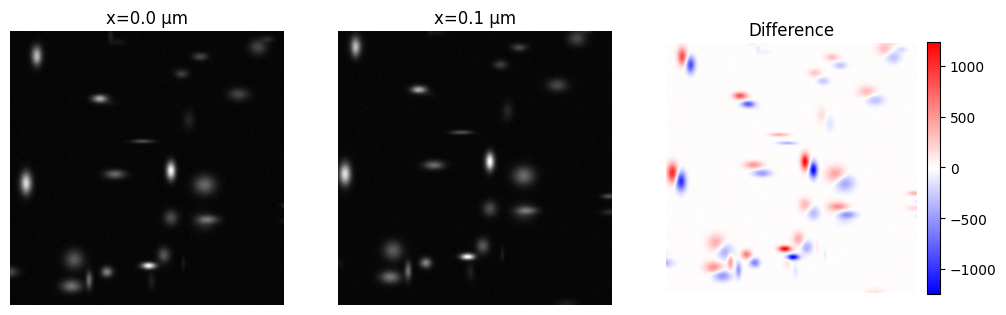

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

stem.device_settings("haadf", size=256, field_of_view_um=30.0, noise_sigma=8.0)
stem.set_mode("IMG")
stem.set_stage({"x": 0.0, "y": 0.0, "z": 0.0}, relative=False)
img0 = stem.acquire_image("haadf")

stem.set_stage({"x": 1e-6, "y": 1e-6}, relative=True)  # 0.1 µm move
img1 = stem.acquire_image("haadf")

diff = img1.astype(np.float32) - img0.astype(np.float32)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img0, cmap="gray"); plt.title("x=0.0 µm"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(img1, cmap="gray"); plt.title("x=0.1 µm"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(diff, cmap="bwr"); plt.title("Difference"); plt.axis("off"); plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


## Demo 2 — FOV Zoom In / Zoom Out
Same stage position, different `field_of_view_um`.

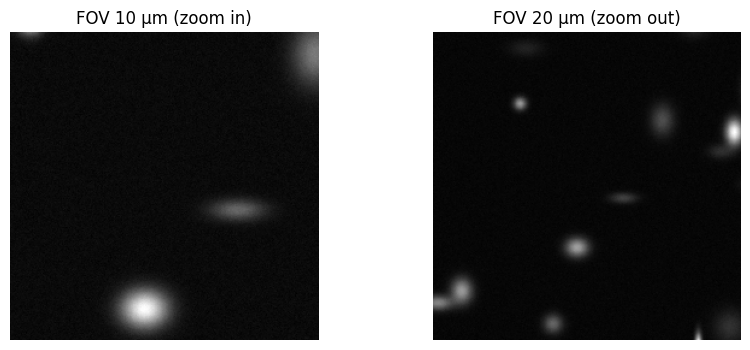

In [ ]:
stem.set_mode("IMG")
stem.set_stage({"x": 15e-6, "y": 25e-6, "z": 0.0}, relative=False)

stem.device_settings("haadf", field_of_view_um=10.0)
zin = stem.acquire_image("haadf")

stem.device_settings("haadf", field_of_view_um=20.0)
zout = stem.acquire_image("haadf")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(zin, cmap="gray"); plt.title("FOV 10 µm (zoom in)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(zout, cmap="gray"); plt.title("FOV 20 µm (zoom out)"); plt.axis("off")
plt.show()


## Demo 3 — Autofocus (defocus blur → sharp)
We intentionally set Z out of focus, run autofocus, then reacquire.

Exception in thread Thread-3 (main):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/twisted/internet/tcp.py", line 1358, in startListening
    skt.bind(addr)
OSError: [Errno 98] Address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/content/stem_server_twisted_colab.py", line 533, in main
    reactor.listenTCP(port, factory, interface=host)
  File "/usr/local/lib/python3.12/dist-packages/twisted/internet/posixbase.py", line 366, in listenTCP
    p.startListening()
  File "/usr/local/lib/python3.12/dist-packages/twisted/internet/tcp.py", line 1360, in startListening
    raise CannotListenError(self.interface, self.port, le)
twisted.internet.error.CannotListenError: Couldn't list

[DT] 3D volume ready.
STEMServer (DT) initialized
Autofocus result: {'best_z_m': 0.0, 'best_z_um_relative': -4.0, 'scores': [[-6.0, 7.154074668884277], [-5.0, 7.52040433883667], [-4.0, 8.160938262939453], [-3.0, 7.548207759857178], [-2.0, 7.152527809143066], [-1.0, 6.8263020515441895], [0.0, 6.530575752258301], [1.0, 5.921629905700684], [2.0, 5.649984836578369], [3.0, 5.390793323516846], [4.0, 5.388480186462402], [5.0, 5.404886722564697], [6.0, 5.394929885864258]]}


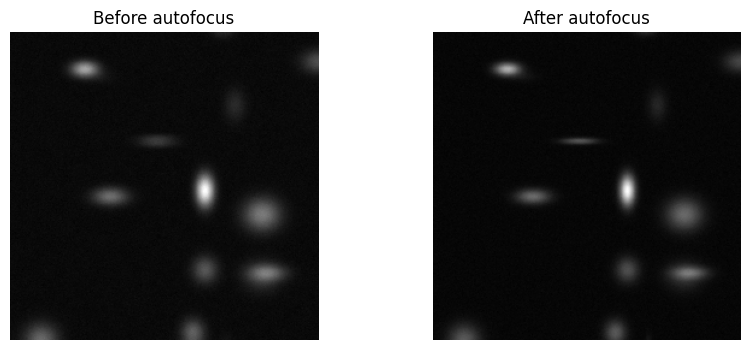

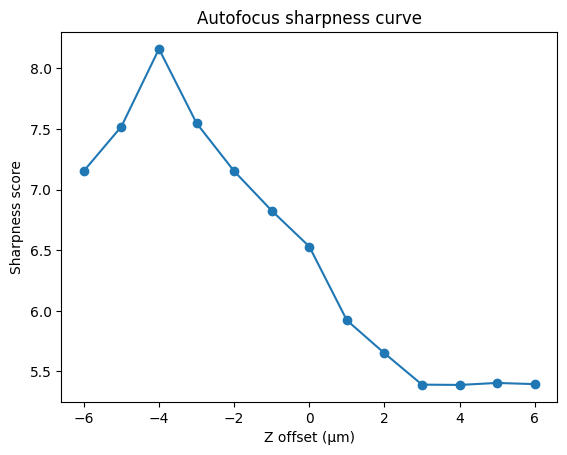

In [ ]:
stem.set_mode("IMG")
# Make it noticeably out of focus
stem.set_stage({"z": 4e-6}, relative=False)  # 4 µm defocus
stem.device_settings("haadf", field_of_view_um=20.0, noise_sigma=8.0)

before = stem.acquire_image("haadf")
af = stem.autofocus(device="haadf", z_range_um=6.0, z_steps=13)
after = stem.acquire_image("haadf")

print("Autofocus result:", af)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(before, cmap="gray"); plt.title("Before autofocus"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(after, cmap="gray"); plt.title("After autofocus"); plt.axis("off")
plt.show()

# Plot sharpness curve
zs = [z for z, s in af["scores"]]
ss = [s for z, s in af["scores"]]
plt.figure()
plt.plot(zs, ss, marker="o")
plt.xlabel("Z offset (µm)")
plt.ylabel("Sharpness score")
plt.title("Autofocus sharpness curve")
plt.show()


## Demo 4 - Beam controls

- `get_beam()` / `set_beam({...})` supporting:
  - `voltage_kV` (accelerating voltage)
  - `current_pA` (beam current proxy)



Stage (centered mapping): [0.0, 0.0, 0.0, 0.0, 0.0]
Beam: {'x': 0.0, 'y': 0.0, 'current_pA': 200.0, 'voltage_kV': 300.0}
Beam after set: {'x': 0.0, 'y': 0.0, 'current_pA': 100.0, 'voltage_kV': 300.0}


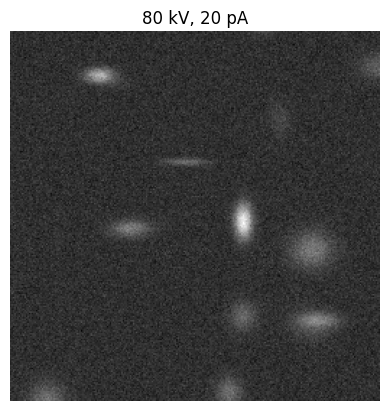

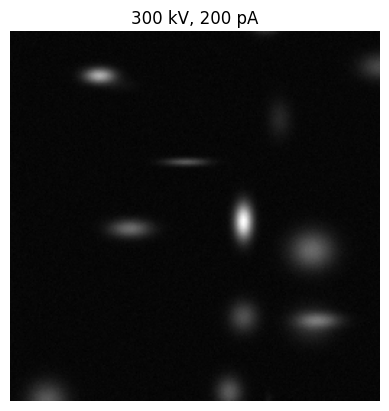

In [ ]:
# Beam settings demo

print("Stage (centered mapping):", stem.get_stage())
print("Beam:", stem.get_beam())
stem.set_mode("IMG")
stem.set_beam({"voltage_kV": 300, "current_pA": 100}, relative=False)
print("Beam after set:", stem.get_beam())

stem.set_beam({"voltage_kV": 80, "current_pA": 20}, relative=False)
img_low = stem.acquire_image("haadf")

stem.set_beam({"voltage_kV": 300, "current_pA": 200}, relative=False)
img_high = stem.acquire_image("haadf")

import matplotlib.pyplot as plt
plt.figure(); plt.imshow(img_low, cmap="gray"); plt.title("80 kV, 20 pA"); plt.axis("off")
plt.figure(); plt.imshow(img_high, cmap="gray"); plt.title("300 kV, 200 pA"); plt.axis("off")
plt.show()


##STEM ↔ Diffraction mode switch

- **IMG** mode returns the real-space image.
- **DIFF** mode returns a diffraction proxy computed from the underlying real-space frame: `log(1 + |FFT2(image - mean)|)`.

This is a digital-twin approximation suitable for automation demos and tilt navigation.


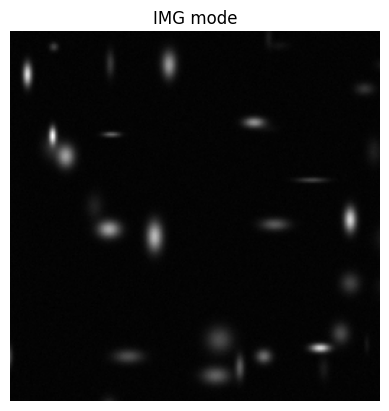

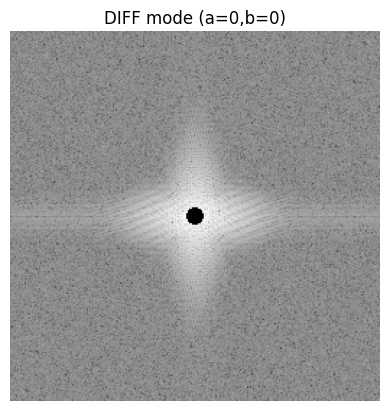

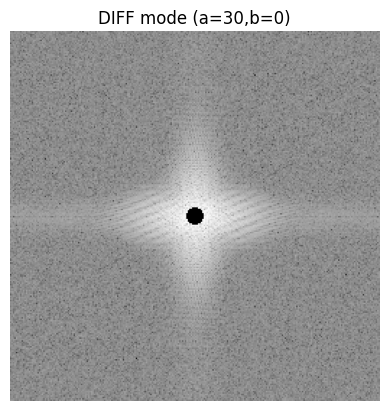

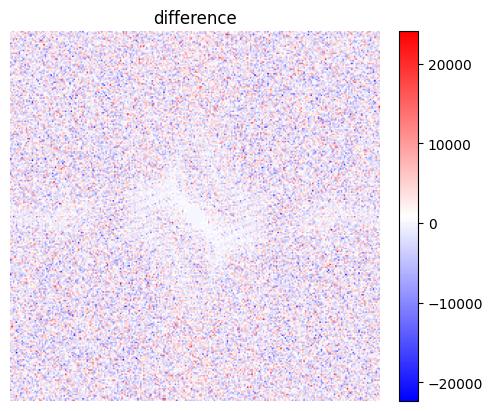

Mode: {'mode': 'DIFF'}
Diff settings: {'camera_length_mm': 800.0, 'beamstop_radius_px': 6.0}


In [ ]:
# Mode switch demo (IMG vs DIFF)
stem.device_settings("haadf", field_of_view_um=30.0, noise_sigma=6.0)
stem.set_stage({"x":-10e-6,"y":0,"z":0,"a":0,"b":0}, relative=False)

stem.set_mode("IMG")
img_stem = stem.acquire_image("haadf")

stem.set_mode("DIFF")
dp0 = stem.acquire_image("haadf")

# Change tilt and compare diffraction
stem.set_stage({"x":-10e-6,"y":0,"z":0, "a": 15, "b": -15}, relative=False)
dp1 = stem.acquire_image("haadf")
diff = dp1.astype(np.float32) - dp0.astype(np.float32)

import matplotlib.pyplot as plt
plt.figure(); plt.imshow(img_stem, cmap="gray"); plt.title("IMG mode"); plt.axis("off")
plt.figure(); plt.imshow(dp0, cmap="gray"); plt.title("DIFF mode (a=0,b=0)"); plt.axis("off")
plt.figure(); plt.imshow(dp1, cmap="gray"); plt.title("DIFF mode (a=30,b=0)"); plt.axis("off")
plt.figure(); plt.imshow(diff, cmap="bwr"); plt.title("difference"); plt.axis("off"); plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

print("Mode:", stem.get_mode())
print("Diff settings:", stem.get_diffraction_settings())


For better understanding of changes in diffraction mode, another sample data is created and plugged into digital twin. This can be found in STEM_DIgital_Twin_FCC.ipynb